<a href="https://colab.research.google.com/github/fseidl-gdit/tutorial_binder/blob/main/Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
import pandas_gbq
import pandas as pd
import numpy
import seaborn
from google.cloud import bigquery
%load_ext rpy2.ipython

bq_project='isb-cgc-etl'
auth.authenticate_user()
client = bigquery.Client(project=bq_project)
print('Authenticated')

Authenticated


In [ ]:
%%R
install.packages('bigrquery')
library(bigrquery)

# Clinical and cohort queries
How old are the patients for each case in a given project?

In [ ]:
%%R
project <- "isb-cgc-etl"

sql <- "select
  submitter_id case_barcode,
  demo__age_at_index age,
  demo__vital_status vital
from `isb-cgc-bq.TCGA.clinical_gdc_current`
where proj__project_id = 'TCGA-BRCA'
"
query <- bq_project_query(project, query=sql)
df <- as.data.frame(bq_table_download(query))
head(df)

R[write to console]: Complete

R[write to console]: Billed: 10.49 MB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



  case_barcode age vital
1 TCGA-A8-A07E  81 Alive
2 TCGA-A8-A099  76 Alive
3 TCGA-A8-A09A  40 Alive
4 TCGA-A8-A09C  69 Alive
5 TCGA-B6-A0I8  46  Dead
6 TCGA-B6-A0RE  61 Alive


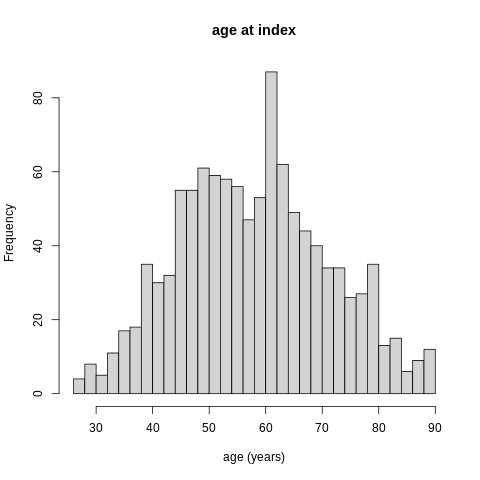

In [ ]:
%%R
hist(df[,2], breaks=length(unique(df[,2]))/2, main='age at index', xlab='age (years)')

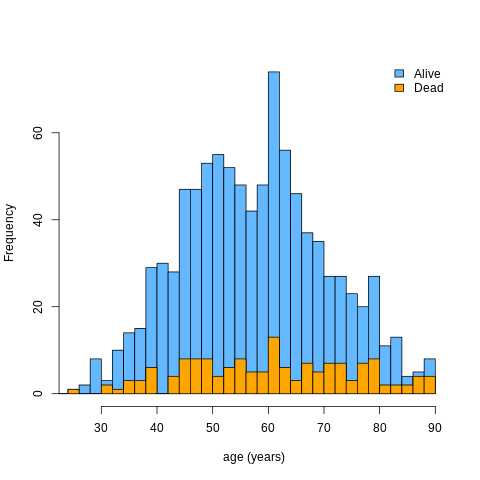

In [ ]:
%%R
hist(df[df[,3] == 'Alive',2], breaks=seq(0,90,2), xlim=c(25,90), col='steelblue1', main='', xlab='age (years)')
hist(df[df[,3] == 'Dead',2], breaks=seq(0,90,2), add=1, col='orange')
legend('topright', bty='n', legend=c('Alive', 'Dead'), fill=c('steelblue1', 'orange'))

# Gene expressionn
What is the mean RNAseq expression (fpkm-uq) of a specific gene in normal and tumor?

Table: *isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current*

In [ ]:
%%R
sql <- "select
  case_barcode,
  aliquot_barcode,
  sample_type_name,
  avg(HTSeq__FPKM_UQ) avg_fpkm
from `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current`
where project_short_name = 'TCGA-BRCA'
and gene_name = 'FOXD4'
group by case_barcode, aliquot_barcode, sample_type_name"

query <- bq_project_query(project, query=sql)
df <- bq_table_download(query)
head(df)

R[write to console]: Complete

R[write to console]: Billed: 0 B

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 6 × 4
  case_barcode aliquot_barcode              sample_type_name avg_fpkm
  <chr>        <chr>                        <chr>               <dbl>
1 TCGA-AN-A0AS TCGA-AN-A0AS-01A-11R-A00Z-07 Primary Tumor       2440.
2 TCGA-A2-A3XX TCGA-A2-A3XX-01A-21R-A239-07 Primary Tumor       3675.
3 TCGA-D8-A1JE TCGA-D8-A1JE-01A-11R-A13Q-07 Primary Tumor       5365.
4 TCGA-BH-A1FE TCGA-BH-A1FE-01A-11R-A13Q-07 Primary Tumor      10674.
5 TCGA-AO-A1KP TCGA-AO-A1KP-01A-11R-A13Q-07 Primary Tumor      11747.
6 TCGA-AN-A0AT TCGA-AN-A0AT-01A-11R-A034-07 Primary Tumor       4712.


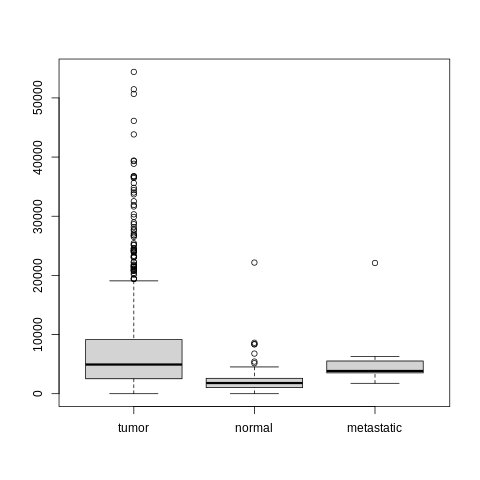

In [ ]:
%%R

tumor <- unlist(df[df[,3] == 'Primary Tumor',4])
normal <- unlist(df[df[,3] == 'Solid Tissue Normal',4])
metastatic <- unlist(df[df[,3] == 'Metastatic',4])

boxplot(list(tumor, normal, metastatic), names=c('tumor', 'normal', 'metastatic'))

We can also generate summary statistics directly in BigQuery.

In [ ]:
%%R
sql <- "select
  sample_type_name,
  avg(HTSeq__FPKM_UQ) avg_fpkm,
  stddev(HTSeq__FPKM_UQ) sdv_fpkm,
  max(HTSeq__FPKM_UQ) max_fpkm,
  min(HTSeq__FPKM_UQ) min_fpkm
from `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current`
where project_short_name = 'TCGA-BRCA'
and gene_name = 'FOXD4'
group by sample_type_name"

query <- bq_project_query(project, query=sql)
df <- bq_table_download(query)
head(df)

R[write to console]: Complete

R[write to console]: Billed: 0 B

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 3 × 5
  sample_type_name    avg_fpkm sdv_fpkm max_fpkm min_fpkm
  <chr>                  <dbl>    <dbl>    <dbl>    <dbl>
1 Metastatic             6539.    6996.   22097.    1752.
2 Primary Tumor          7114.    7077.   54396.       0 
3 Solid Tissue Normal    2266.    2481.   22164.       0 


#Genome annotation
We can retrieve Gencode annotation data for specific genes from BigQuery tables

Table: *isb-cgc-bq.GENCODE_versioned.annotation_gtf_hg38_v22*

In [ ]:
%%R
sql1 <- "select * from `isb-cgc-bq.GENCODE_versioned.annotation_gtf_hg38_v22` where gene_name = 'FOXD4' and feature = 'gene'"

query1 <- bq_project_query(project, query=sql1)
df1 <- bq_table_download(query1)
head(df1)

R[write to console]: Complete

R[write to console]: Billed: 0 B

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 1 × 32
  seq_name source feature  start    end frame strand gene_name gene_id gene_id_v
  <chr>    <chr>  <chr>    <int>  <int> <chr> <chr>  <chr>     <chr>   <chr>    
1 chr9     HAVANA gene    116231 118204 .     -      FOXD4     ENSG00… ENSG0000…
# … with 22 more variables: gene_type <chr>, gene_status <chr>,
#   transcript_name <chr>, transcript_id <chr>, transcript_id_v <chr>,
#   transcript_status <chr>, transcript_type <chr>,
#   transcript_support_level <int>, exon_number <int>, exon_id <chr>,
#   exon_id_v <chr>, ccds_id <chr>, ccds_id_v <chr>, protein_id <chr>,
#   protein_id_v <chr>, havana_gene <chr>, havana_gene_v <chr>,
#   havana_transcript <chr>, havana_transcript_v <chr>, level <int>, …


# Mutation data
Given the gene annotation data above we can query for mutations within a gene.

Table: *isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current*

In [ ]:
%%R
sql2 <- "select case_barcode, 
    Chromosome, 
    Start_Position, 
    End_Position, 
    Reference_Allele, 
    Tumor_Seq_Allele1, 
    Tumor_Seq_Allele2
from `isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current`
where Chromosome = 'chr9'
    and Start_Position > 116231
    and End_Position < 118204"

query2 <- bq_project_query(project, query=sql2)
df2 <- bq_table_download(query2)
head(df2)

R[write to console]: Complete

R[write to console]: Billed: 0 B

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 6 × 7
  case_barcode Chromosome Start_Position End_Position Reference_Allele
  <chr>        <chr>               <int>        <int> <chr>           
1 TCGA-EO-A3AV chr9               116673       116673 T               
2 TCGA-IG-A6QS chr9               116510       116510 T               
3 TCGA-WR-A838 chr9               116510       116510 T               
4 TCGA-AP-A1DV chr9               118154       118154 C               
5 TCGA-YC-A89H chr9               118147       118147 G               
6 TCGA-AP-A1DV chr9               117727       117727 G               
# … with 2 more variables: Tumor_Seq_Allele1 <chr>, Tumor_Seq_Allele2 <chr>


What about in the 500 kB upstream and downstream of the gene?

In [ ]:
%%R
sql <- "select case_barcode, 
    Chromosome, 
    Start_Position, 
    End_Position, 
    Reference_Allele, 
    Tumor_Seq_Allele1, 
    Tumor_Seq_Allele2
from `isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current`
where 
    Chromosome = 'chr9'
    and (
        (Start_Position < 116231 and Start_Position > 66231)
        or (End_Position > 118204 and End_Position < 168204)
        )"

query <- bq_project_query(project, query=sql)
df <- bq_table_download(query)
head(df)

R[write to console]: Complete

R[write to console]: Billed: 164.63 MB

R[write to console]: Downloading first chunk of data.

R[write to console]: First chunk includes all requested rows.



# A tibble: 6 × 7
  case_barcode Chromosome Start_Position End_Position Reference_Allele
  <chr>        <chr>               <int>        <int> <chr>           
1 TCGA-EY-A215 chr9               166052       166052 A               
2 TCGA-XF-A9ST chr9               123241       123241 G               
3 TCGA-SX-A7SP chr9               118210       118210 A               
4 TCGA-BH-A18U chr9               156515       156515 C               
5 TCGA-14-0866 chr9               121423       121423 T               
6 TCGA-BS-A0VI chr9               166071       166071 G               
# … with 2 more variables: Tumor_Seq_Allele1 <chr>, Tumor_Seq_Allele2 <chr>


# Table joins
How do we join clinical and mutation data?

Tables: 
*   *isb-cgc-bq.TCGA.clinical_gdc_current*
*   *isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current*




In [ ]:
%%R
sql <- "select 
    mut.Chromosome, 
    mut.Start_Position, 
    mut.End_Position, 
    mut.Reference_Allele, 
    mut.Tumor_Seq_Allele1, 
    mut.Tumor_Seq_Allele2, 
    clin.demo__vital_status 
from `isb-cgc-bq.TCGA.clinical_gdc_current` clin
join `isb-cgc-bq.TCGA.somatic_mutation_hg38_gdc_current` mut 
    on clin.submitter_id = mut.case_barcode
where mut.project_short_name = 'TCGA-BRCA'"

query <- bq_project_query(project, query=sql)
df <- bq_table_download(query)
head(df)